#Assignment 3:
    test if the distribution of ages can be modelled by a Gaussian
    
    1) all riders
    
    2) summer riders vs winder riders
    
    use 2 tests, you can use KS, AD, or get creative. use KL or chi2 like you did in Assignment2 or perhaps new ones!
    
    CHALLANGE! look for a better distribution to fit the data! see notes on how to input a number of different 
    distributions into the test, not just 'norm' and the few others available by keyword

my usual imports and setups

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
pl.rcParams.update(s)

np.random.seed(2015)

#i know i will use scipy for the tests
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import zipfile
import StringIO


def urlZipToDF(url):
    name = url.split('/')[-1].replace('zip','csv')
    r = requests.get(url)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    csvZ = [x for x in z.namelist() if '.csv' in x][0] #simply first csv in list
    return pd.read_csv(z.open(csvZ))


def getCitibikeData(year, month):
    url = 'https://s3.amazonaws.com/tripdata/%d%s-citibike-tripdata.zip' %(year, ("%02d" % month))
    return urlZipToDF(url)

In [3]:
w1 = getCitibikeData(2013,12)
w2 = getCitibikeData(2014,1)

In [4]:
winter = pd.concat([w1,w2])

In [5]:
s1  = getCitibikeData(2014,6)
s2  = getCitibikeData(2014,7)

summer = pd.concat([s1,s2])

I need 2 seasons, lets start reading in data from January 2015, and June 2015. 
One month is not a season. You should import data from other months in the winter as well, and then several summer months to get the other distribution. I am being lazy but you should not be. 



## get the age like we did before, subscribers only cause otherwise the ages are really sparse anyways


In [6]:
#df is the dataframe where the content of the csv file is stored
summer = summer[summer['usertype'] == 'Subscriber']
winter = winter[winter['usertype'] == 'Subscriber']

In [7]:
winter['age'] = 2015-winter['birth year'].astype(float)

In [8]:
#my Summer datum is durty, have to cleen it

def tryFloat(x):
    if '\N' in x:
        return None
    else: 
        return float(x)
        

summer['birth year'] = summer['birth year'].apply(tryFloat)

In [9]:
summer['age'] = 2015-summer['birth year'].astype(float)

lets split age in 10 year bins. see the comment in assignment 1 about this

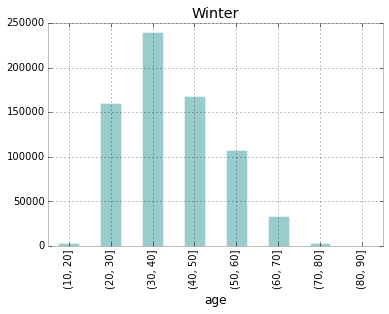

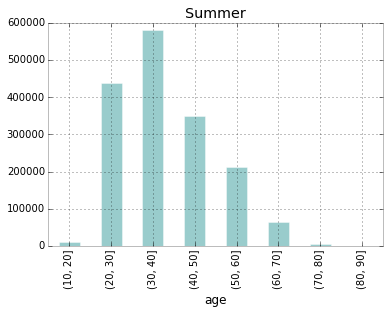

In [12]:
bins = np.arange(10, 99, 10)

winter.age.groupby(pd.cut(winter.age, bins)).agg([count_nonzero]).plot(kind='bar', legend=0, alpha = 0.4,  color='teal', title='Winter')
summer.age.groupby(pd.cut(summer.age, bins)).agg([count_nonzero]).plot(kind='bar', legend=0, alpha = 0.4,  color='teal', title="Summer")


W_age_dist = winter.age.groupby(pd.cut(winter.age, bins)).agg([count_nonzero])
S_age_dist = summer.age.groupby(pd.cut(summer.age, bins)).agg([count_nonzero])
    

how do they look? what should I expect? setting some expectation is useful as a sanity check!

lets run the scipy KS test

#KS testsfor goodness of fit

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [16]:
#compare to normal

ksW=scipy.stats.kstest(W_age_dist, 'norm')
ksS=scipy.stats.kstest(S_age_dist, 'norm')
print "winter, normal fit", ksW
print "summer, normal fit", ksS

#compare to poisson 

ksW=scipy.stats.kstest(W_age_dist, 'cauchy')
ksS=scipy.stats.kstest(S_age_dist, 'cauchy')
print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=1.0, pvalue=0.0)
summer, normal fit KstestResult(statistic=1.0, pvalue=0.0)
winter, normal fit KstestResult(statistic=0.99999867471933412, pvalue=0.0)
summer, normal fit KstestResult(statistic=0.99999945320357075, pvalue=0.0)


the scipy KS test works with keywords only for scipy.stats distributions 
that take as a single argument the size of the sample, like norm and cauchy look them up to make sure I am right!
if i want to test against a distribution which takes more arguments like Poisson, which in scipy.stats takes the 
lambda parameter and the size (2 arguments) i can pass the extra arguments in arg, like i do below: 

In [ ]:
ksW=scipy.stats.kstest(W_age_dist, 'gamma', args=(35,))
ksS=scipy.stats.kstest(S_age_dist, 'gamma', args=(35,))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

or i can create my function separately, then call it: all i need to do is define a function that calls  like i am doing below. the size argument must come first, and the second argument of kstest will no longer be a string, but the function itself (what we would call a "callable")

In [23]:
def mydistribution(size, m0, m1):
    #this is a crazy dumb function, but i am trying to make a point here...
    return (np.empty_like(size)+1) * m0 **2

In [24]:
ksW=scipy.stats.kstest(W_age_dist, mydistribution, args=(35,38))
ksS=scipy.stats.kstest(S_age_dist, mydistribution, args=(35,38))

print "winter, normal fit", ksW
print "summer, normal fit", ksS

winter, normal fit KstestResult(statistic=2296.875, pvalue=nan)
summer, normal fit KstestResult(statistic=294225400.0, pvalue=nan)


##TODO FOR YOU!

-- repeat with the AD test, and/or any other tests you wish

-- do you see differences in the sample? significant differences?

-- do you dare (and this is indeed optional but could be fun) splitting the samples by up- and down-town?

In [25]:
adW=scipy.stats.anderson(W_age_dist['count_nonzero'], dist='norm')
print "Winter on normal", adW
adS=scipy.stats.anderson(S_age_dist['count_nonzero'], dist='norm')
print "Summer on normal", adS

Winter on normal AndersonResult(statistic=0.47194121938404265, critical_values=array([ 0.519,  0.591,  0.709,  0.827,  0.984]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Summer on normal AndersonResult(statistic=0.47063092910974369, critical_values=array([ 0.519,  0.591,  0.709,  0.827,  0.984]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


**Philipp**: It looks like that statistics is pretty small in both cases so we can reject Null Hypotesis that any of those samples are formed by normal distribution

In [27]:
ks=scipy.stats.ks_2samp(winter.age.dropna(), summer.age.dropna())
print ks

Ks_2sampResult(statistic=0.055185188853269729, pvalue=0.0)
